In [157]:
import numpy as np
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import colormaps


def plot(input_data, *args, **kwargs):
    # This function plots the alluvial diagram
    # It allows the user to use this module without seeing its internals!!!!!!!!!!!!!!!!! It's magic!!!
    # TODO: Turn this function into a static method in AlluvialTool
    at = AlluvialTool(input_data, *args, **kwargs)
    ax = at.plot(**kwargs)
    ax.axis('off')
    return ax


class AlluvialTool:
    def __init__(
            self,
            input_data=(),
            x_range=(0, 1),
            res=20,
            h_gap_frac=0.03,
            v_gap_frac=0.03,
            **kwargs):
        # TODO: Break __init__ into several smaller sub-methods that do one thing each!
        # TODO: Turn all "getters" into setters or generate methods
        # TODO: Add documentation to methods
        self.input = input_data  # Describes pairs of labels from 2 categories (e.g. "country" - "spoken language")
        self.x_range = x_range  # Diagram coordinates in x-axis
        self.res = res  # Defines the number of spline points used to draw veins
        self.h_gap_frac = h_gap_frac  # Defines the horizontal distance between matplotlib patches (relative to x_range)
        self.v_gap_frac = v_gap_frac  # Defines the vertical distance between matplotlib patches (relative to max y)
        self.vein_blueprint = self.make_vein_blueprint_arrays()
        self.input_data_dict = self.read_input()  # TODO: Consider explicitly passing input_data
        self.item_width_dict = self.get_item_width_dict()
        self.src_group, self.dst_group = self.groups = self.get_ordered_label_groups(**kwargs)
        # TODO: get h_gap and v_gap from method/s
        self.h_gap = x_range[1] * h_gap_frac
        self.v_gap = sum(
            [width for b_item_counter in self.input_data_dict.values()
             for width in b_item_counter.values()]
        ) * v_gap_frac
        self.group_widths = self.get_group_widths()
        self.item_coord_dict = self.generate_item_coordinate_dict()
        self.alluvial_fan = self.generate_alluvial_fan()
        self.item_text_len, self.width_text_len = self.get_vein_label_lengths()

    def make_vein_blueprint_arrays(self):
        y = np.array([0, 0.15, 0.5, 0.85, 1])
        x = np.linspace(self.x_range[0], self.x_range[-1], len(y))
        z = np.polyfit(x, y, 4)
        f = np.poly1d(z)

        blueprint_x_vals = np.linspace(x[0], x[-1], self.res)
        blueprint_y_vals = f(blueprint_x_vals)
        return blueprint_x_vals, blueprint_y_vals

    def get_vein_polygon_xy(self, y_range, width):
        x, y = self.vein_blueprint
        y0, yn = y_range
        scale = yn - y0 
        ty = y * scale + y0
        x_new = np.concatenate([x, x[::-1], ])
        y_new = np.concatenate([ty, ty[::-1] + width ])
        return np.array([x_new, y_new]).transpose()

    def read_input_from_list(self):
        data_table = np.array(self.input)
        data_dic = defaultdict(Counter)
        for line in data_table:
            data_dic[line[0]][line[1]] += 1
        return data_dic

    def read_input_from_dict(self):
        # data_dic = self.input
        # data_table = []
        # for x_item, y_item_counter in data_dic.items():
        #     for y_item, count in y_item_counter.items():
        #         data_table += [[x_item, y_item]] * count
        # data_table = np.array(sorted(data_table))
        # return data_table, data_dic
        return self.input

    def read_input(self):
        if type(self.input) == dict:
            return self.read_input_from_dict()
        else:
            return self.read_input_from_list()

    def get_item_width_dict(self):
        iwd = Counter()  # item_width_dict
        for src_item_label, dst_width_dict in self.input_data_dict.items():
            for dst_item_label, width in dst_width_dict.items():
                iwd[src_item_label] += width
                iwd[dst_item_label] += width
        return iwd
    def get_ordered_label_groups(self, src_label_override=None, dst_label_override=None, **kwargs):
            # TODO: Remove code duplication from creation of src, dst lists
            _ = kwargs
    
            src_ordered_labels = src_label_override if src_label_override else sorted(
                {src_item for src_item in self.input_data_dict}, key=lambda x: self.item_width_dict[x])
    
            dst_ordered_labels = dst_label_override if dst_label_override else sorted(
                {dst_item for dst_item_counter in self.input_data_dict.values() for dst_item in dst_item_counter},
                key=lambda x: self.item_width_dict[x])
    
            return src_ordered_labels, dst_ordered_labels



  

    def get_group_widths(self):
        return [self.get_group_width(group) for group in (self.src_group, self.dst_group)]

    def get_group_width(self, group):
        return sum([self.item_width_dict[item] for item in group]) + (len(group) - 1) * self.v_gap

    def generate_item_coordinate_dict(self, ):
        item_coord_dict = defaultdict(ItemCoordRecord)
        for ind, group in enumerate(self.groups):
            
            last_pos = (max(self.group_widths) - self.group_widths[ind]) / 2
            # TODO: Move inner for loop into a method
            for item in group:
                width = self.item_width_dict[item]
                xy = (self.x_range[ind], last_pos)
                item_coord_dict[item].set_start_state(width, xy, side=ind)
                last_pos += width + self.v_gap
        return item_coord_dict




    


    def generate_alluvial_vein(self, src_item, dst_item):
        # TODO: Move coordinate allocation from here to ItemCoordRecord and rename to allocator
        width = self.input_data_dict[src_item][dst_item]
        src_item_coord = self.item_coord_dict[src_item].read_state()
        dst_item_coord = self.item_coord_dict[dst_item].read_state_and_advance_y(width)
        y_range = (src_item_coord[1], dst_item_coord[1])
        return self.get_vein_polygon_xy(y_range, width)

    def get_label_rectangles_xy(self, a_item, b_item):
        width = self.input_data_dict[a_item][b_item]
        return (
            self.generate_item_sub_rectangle(a_item, width),
            self.generate_item_sub_rectangle(b_item, width),
        )

    def generate_item_sub_rectangle(self, item, width):
        dic_entry = self.item_coord_dict[item]
        item_coord = dic_entry.read_state()
        sign = dic_entry.get_side_sign()
        return self.get_rectangle_xy(item_coord, width, sign)

    def get_rectangle_xy(self, item_coord, width, sign):
        x, y = item_coord
        rect = [[
            x + sign * 0.5 * (0.5 + xa) * self.h_gap,
            y + ya * width,
        ] for xa, ya in ((0, 1), (0, 0), (1, 0), (1, 1))]
        return np.array(rect)
            
    def generate_alluvial_fan(self):
        alluvial_fan = OrderedDict()
    
        custom_source_positions = {
            "Oceania": 80000000,
            "Africa": 72000000,
            "Asia": 55000000,
            "Central/South America": 35000000,
            "Europe": 20000000,
            "North America": 1090000
        }
    
        print("\n🔹 Ensuring Source Order in Fan Generation:", self.src_group)
    
        flow_data = []
    
        for src_item in self.src_group:
            for dst_item in self.dst_group:
                if dst_item in self.input_data_dict[src_item]:
                    width = self.input_data_dict[src_item][dst_item]
                    src_y = custom_source_positions.get(src_item, self.item_coord_dict[src_item].get_y())
    
                    src_item_coord = (self.item_coord_dict[src_item].get_x(), src_y)
                    dst_item_coord = self.item_coord_dict[dst_item].read_state_and_advance_y(width)
                    y_range = (src_item_coord[1], dst_item_coord[1])
    
                    flow_data.append((width, src_item, dst_item, src_item_coord, dst_item_coord, y_range))
    
        flow_data.sort(reverse=True, key=lambda x: x[0])  # ✅ Sort by width (largest first)
    
        alluvial_fan_layers = []  # ✅ Store flows with z-order
    
        for index, (width, src_item, dst_item, src_item_coord, dst_item_coord, y_range) in enumerate(flow_data):
            vein_polygon = self.get_vein_polygon_xy(y_range, width)
    
            if len(vein_polygon) == 0:
                print(f"❌ Empty polygon for {src_item} → {dst_item}. Skipping.")
                continue
    
            z_order = len(flow_data) - index  # ✅ Assign higher z-order to wider flows
    
            print(f"✅ Layering Flow {src_item} → {dst_item}, Width: {width}, Z-Order: {z_order}")
    
            alluvial_fan[(src_item, dst_item)] = [
                vein_polygon,
                self.get_rectangle_xy(src_item_coord, width, self.item_coord_dict[src_item].get_side_sign()),
                self.get_rectangle_xy(dst_item_coord, width, self.item_coord_dict[dst_item].get_side_sign()),
            ]
            
            # ✅ Store z_order separately for later use in the plot function
            alluvial_fan_layers.append((vein_polygon, z_order))
    
        self.alluvial_fan_layers = alluvial_fan_layers  # ✅ Save z-order separately
        return alluvial_fan





    
        
    def plot(self, figsize=(10, 15), alpha=0.5, **kwargs):
        colors = self.get_color_array(**kwargs)
        fig, ax = plt.subplots(figsize=figsize)
    
        for ind, (vein_polygon, z_order) in enumerate(self.alluvial_fan_layers):
            if len(vein_polygon) == 0:
                continue  # Skip empty polygons
    
            patch = Polygon(vein_polygon, facecolor=colors[ind], alpha=alpha, zorder=z_order)
            ax.add_patch(patch)
    
        self.auto_label_veins(**kwargs)
        self.label_sides(**kwargs)
        ax.autoscale()
        return ax



    def get_color_array(self, colors=None, color_side=0, rand_seed=1, cmap=None, **kwargs):
        _ = kwargs
        color_items = self.dst_group if color_side else self.src_group
        lci = len(color_items)
        if rand_seed is not None:
            np.random.seed(rand_seed)
        cmap = cmap if cmap is not None else colormaps['hsv']
        color_array = colors if colors is not None else [
            cmap(item) for ind, item in enumerate(np.random.rand(lci))]
        ind_dic = {item: ind for ind, item in enumerate(color_items)}
        polygon_colors = []
        for a_item, b_item, in self.alluvial_fan:
            item = b_item if color_side else a_item
            polygon_colors += [color_array[ind_dic[item]]]
        return np.array(polygon_colors)

    def get_vein_label_lengths(self):
        item_text_len = max([len(it) for it in self.item_width_dict], default=0)
        width_text_len = max([len(str(w)) for w in self.item_width_dict.values()], default=0)
        return item_text_len, width_text_len

    def auto_label_veins(self, fontname='Monospace', **kwargs):
        # shift = max([len(item) for item in self.item_coord_dic.keys()]) / 50
        for item, vein in self.item_coord_dict.items():
            y_width = vein.get_width()
            sign = vein.get_side_sign()
            print(sign)
            side = int(sign + 1) // 2
            ha = 'left' if side else 'right'
            plt.text(
                vein.get_x() + 1.5 * sign * self.h_gap,
                vein.get_y() + y_width / 2,
                self.item_text(item, side, **kwargs),
                    ha=ha, va='center', fontname=fontname)
    def label_sides(
            self,
            labels=None,
            label_shift=0,
            disp_width=False,
            wdisp_sep=7 * ' ',
            fontname='Arial',
            **kwargs):
    
        print("\n🔹 `label_sides()` function was called!")  # ✅ First Debugging Print
    
        if labels is None:
            print("❌ `labels` is None. Exiting function early!")
            return  # ✅ Exit early if no labels are provided
    
        _ = kwargs
        y = max(self.group_widths) / 2
        itl, wtl = self.item_text_len, self.width_text_len
    
        print(f"🔹 Labels Received: {labels}")  # ✅ Check what labels are passed
    
        for side, sign in enumerate((-1, 1)):
            x_position = self.x_range[side] + sign * (
                    label_shift + itl + int(disp_width) * (len(wdisp_sep) + wtl)
            ) * self.h_gap_frac
    
            # ✅ Debugging Statements
            print(f"✅ Processing Label: {labels[side]}")
            print(f"   → X Position: {x_position}")
            print(f"   → Y Position: {y}")
            print(f"   → Side: {'Left' if sign == -1 else 'Right'}")
    
            plt.text(
                x_position,
                y,
                labels[side],
                ha='center',
                va='center',
                fontname=fontname,
                fontsize=13,
                rotation=90 - 180 * side
            )


    def item_text(
            self, item, side,
            disp_width=False, wdisp_sep=7 * ' ', width_in=True, **kwargs):
        _ = kwargs
        f_item = item
        # f_item = bidi.algorithm.get_display(item)  # for RTL languages
        tal = '<' if f_item == item else '>'
        if not disp_width:
            ans = ('{:%s}' % tal).format(item)
        else:
            width = self.item_coord_dict[item].get_width()
            if side and width_in or (not side and not width_in):
                lc, rc, wl, wr, tl, tr = '>', tal, self.width_text_len, self.item_text_len, width, f_item,
            else:
                lc, rc, wl, wr, tl, tr = tal, '>', self.item_text_len, self.width_text_len, f_item, width,
            pat = '{:%s%d}%s{:%s%d}' % (lc, wl, wdisp_sep, rc, wr,)
            ans = pat.format(tl, tr, )
        return ans


class ItemCoordRecord:
    def __init__(self, ):
        self.width = 0
        self.xy = ()
        self.curr_xy = self.xy[:]
        self.side = -1

    def set_start_state(self, width, xy, side):
        self.width = width
        self.xy = xy
        self.curr_xy = list(self.xy[:])
        self.side = side

    def read_state_and_advance_y(self, width):
        out = self.curr_xy[:]
        self.curr_xy[1] += width
        return out

    def read_state_and_advance_x(self, width):
        out = self.curr_xy[:]
        self.curr_xy[0] += width
        return out

    def read_state(self):
        return self.curr_xy[:]

    def get_xy(self, ):
        return self.xy

    def get_x(self, ):
        return self.xy[0]

    def get_y(self, ):
        return self.xy[1]

    def get_width(self, ):
        return self.width

    def get_side_sign(self, ):
        return 1 if self.side else -1


In [159]:
import pandas as pd
custom_row_order = ['North America', 'Europe', 'Central/South America', 'Asia', 'Africa', 'Oceania']

custom_column_order = ['Africa', 'Europe', 'Asia', 'North America', 'Central/South America', 'Oceania']

# Load the original dataset
df_original = pd.read_csv("migration.csv")

# Ensure 'origin' is the index before reordering
df_original.set_index('origin', inplace=True)

# Reorder rows and columns
df_ordered = df_original.loc[custom_row_order, custom_column_order]

# Reset index to keep 'origin' as a column
df_ordered = df_ordered.reset_index()
df_ordered

,origin,Africa,Europe,Asia,North America,Central/South America,Oceania
0,North America,63080,1242564,297608,96102,276908,52303
1,Europe,177326,2862931,372138,65649,16758,127524
2,Central/South America,22652,1764867,162077,3627847,879198,36031
3,Asia,242529,3372556,13182962,3725097,57782,1000516
4,Africa,3832478,2108632,681505,540887,12316,155988
5,Oceania,4747,171251,33163,27137,1785,190706


In [161]:
 # Transform the data into the desired dictionary format

# Set the 'origin' column as the index
df_ordered.set_index('origin', inplace=True)

# Convert the DataFrame into a dictionary of dictionaries
input_data = df_ordered.to_dict(orient='index')

# Display the structured dictionary
input_data

{'North America': {'Africa': 63080,
  'Europe': 1242564,
  'Asia': 297608,
  'North America': 96102,
  'Central/South America': 276908,
  'Oceania': 52303},
 'Europe': {'Africa': 177326,
  'Europe': 2862931,
  'Asia': 372138,
  'North America': 65649,
  'Central/South America': 16758,
  'Oceania': 127524},
 'Central/South America': {'Africa': 22652,
  'Europe': 1764867,
  'Asia': 162077,
  'North America': 3627847,
  'Central/South America': 879198,
  'Oceania': 36031},
 'Asia': {'Africa': 242529,
  'Europe': 3372556,
  'Asia': 13182962,
  'North America': 3725097,
  'Central/South America': 57782,
  'Oceania': 1000516},
 'Africa': {'Africa': 3832478,
  'Europe': 2108632,
  'Asia': 681505,
  'North America': 540887,
  'Central/South America': 12316,
  'Oceania': 155988},
 'Oceania': {'Africa': 4747,
  'Europe': 171251,
  'Asia': 33163,
  'North America': 27137,
  'Central/South America': 1785,
  'Oceania': 190706}}


🔹 Ensuring Source Order in Fan Generation: ['Oceania', 'Africa', 'Asia', 'Central/South America', 'Europe', 'North America']
✅ Layering Flow Asia → Asia, Width: 13182962, Z-Order: 36
✅ Layering Flow Africa → Africa, Width: 3832478, Z-Order: 35
✅ Layering Flow Asia → North America, Width: 3725097, Z-Order: 34
✅ Layering Flow Central/South America → North America, Width: 3627847, Z-Order: 33
✅ Layering Flow Asia → Europe, Width: 3372556, Z-Order: 32
✅ Layering Flow Europe → Europe, Width: 2862931, Z-Order: 31
✅ Layering Flow Africa → Europe, Width: 2108632, Z-Order: 30
✅ Layering Flow Central/South America → Europe, Width: 1764867, Z-Order: 29
✅ Layering Flow North America → Europe, Width: 1242564, Z-Order: 28
✅ Layering Flow Asia → Oceania, Width: 1000516, Z-Order: 27
✅ Layering Flow Central/South America → Central/South America, Width: 879198, Z-Order: 26
✅ Layering Flow Africa → Asia, Width: 681505, Z-Order: 25
✅ Layering Flow Africa → North America, Width: 540887, Z-Order: 24
✅ Laye

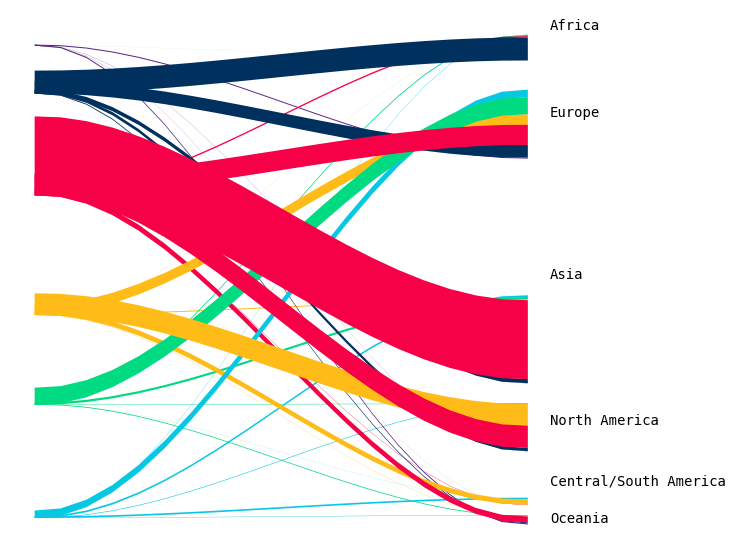

In [163]:
color_list = ['#5C2483','#00305D', '#F60048','#FFBB18', '#00DA80','#07C8E3' ]

ax = plot(input_data,custom_y_positions={
    "Oceania": 100,
    "Africa": 92,
    "Asia": 80,
    "Central/South America": 35,
    "Europe": 20,
    "North America": 10
},src_label_override=['Oceania', 'Africa',  'Asia','Central/South America', 'Europe', 'North America'], 
          dst_label_override=['Oceania', 'Central/South America',  'North America','Asia', 'Europe', 'Africa'], alpha=1, colors=color_list)
fig = ax.get_figure()
fig.set_size_inches(7,7)


In [149]:
import numpy as np
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import colormaps


def plot(input_data, *args, **kwargs):
    # This function plots the alluvial diagram
    # It allows the user to use this module without seeing its internals!!!!!!!!!!!!!!!!! It's magic!!!
    # TODO: Turn this function into a static method in AlluvialTool
    at = AlluvialTool(input_data, *args, **kwargs)
    ax = at.plot(**kwargs)
    ax.axis('off')
    return ax


class AlluvialTool:
    def __init__(
            self,
            input_data=(),
            x_range=(0, 1),
            res=20,
            h_gap_frac=0.03,
            v_gap_frac=0.03,
            **kwargs):
        # TODO: Break __init__ into several smaller sub-methods that do one thing each!
        # TODO: Turn all "getters" into setters or generate methods
        # TODO: Add documentation to methods
        self.input = input_data  # Describes pairs of labels from 2 categories (e.g. "country" - "spoken language")
        self.x_range = x_range  # Diagram coordinates in x-axis
        self.res = res  # Defines the number of spline points used to draw veins
        self.h_gap_frac = h_gap_frac  # Defines the horizontal distance between matplotlib patches (relative to x_range)
        self.v_gap_frac = v_gap_frac  # Defines the vertical distance between matplotlib patches (relative to max y)
        self.vein_blueprint = self.make_vein_blueprint_arrays()
        self.input_data_dict = self.read_input()  # TODO: Consider explicitly passing input_data
        self.item_width_dict = self.get_item_width_dict()
        self.src_group, self.dst_group = self.groups = self.get_ordered_label_groups(**kwargs)
        # TODO: get h_gap and v_gap from method/s
        self.h_gap = x_range[1] * h_gap_frac
        self.v_gap = sum(
            [width for b_item_counter in self.input_data_dict.values()
             for width in b_item_counter.values()]
        ) * v_gap_frac
        self.group_widths = self.get_group_widths()
        self.item_coord_dict = self.generate_item_coordinate_dict()
        self.alluvial_fan = self.generate_alluvial_fan()
        self.item_text_len, self.width_text_len = self.get_vein_label_lengths()

    def make_vein_blueprint_arrays(self):
        y = np.array([0, 0.15, 0.5, 0.85, 1])
        x = np.linspace(self.x_range[0], self.x_range[-1], len(y))
        z = np.polyfit(x, y, 4)
        f = np.poly1d(z)

        blueprint_x_vals = np.linspace(x[0], x[-1], self.res)
        blueprint_y_vals = f(blueprint_x_vals)
        return blueprint_x_vals, blueprint_y_vals

    def get_vein_polygon_xy(self, y_range, width):
        x, y = self.vein_blueprint
        y0, yn = y_range
        scale = yn - y0 
        ty = y * scale + y0
        x_new = np.concatenate([x, x[::-1], ])
        y_new = np.concatenate([ty, ty[::-1] + width ])
        return np.array([x_new, y_new]).transpose()

    def read_input_from_list(self):
        data_table = np.array(self.input)
        data_dic = defaultdict(Counter)
        for line in data_table:
            data_dic[line[0]][line[1]] += 1
        return data_dic

    def read_input_from_dict(self):
        # data_dic = self.input
        # data_table = []
        # for x_item, y_item_counter in data_dic.items():
        #     for y_item, count in y_item_counter.items():
        #         data_table += [[x_item, y_item]] * count
        # data_table = np.array(sorted(data_table))
        # return data_table, data_dic
        return self.input

    def read_input(self):
        if type(self.input) == dict:
            return self.read_input_from_dict()
        else:
            return self.read_input_from_list()

    def get_item_width_dict(self):
        iwd = Counter()  # item_width_dict
        for src_item_label, dst_width_dict in self.input_data_dict.items():
            for dst_item_label, width in dst_width_dict.items():
                iwd[src_item_label] += width
                iwd[dst_item_label] += width
        return iwd
    def get_ordered_label_groups(self, src_label_override=None, dst_label_override=None, **kwargs):
            # TODO: Remove code duplication from creation of src, dst lists
            _ = kwargs
    
            src_ordered_labels = src_label_override if src_label_override else sorted(
                {src_item for src_item in self.input_data_dict}, key=lambda x: self.item_width_dict[x])
    
            dst_ordered_labels = dst_label_override if dst_label_override else sorted(
                {dst_item for dst_item_counter in self.input_data_dict.values() for dst_item in dst_item_counter},
                key=lambda x: self.item_width_dict[x])
    
            return src_ordered_labels, dst_ordered_labels



  

    def get_group_widths(self):
        return [self.get_group_width(group) for group in (self.src_group, self.dst_group)]

    def get_group_width(self, group):
        return sum([self.item_width_dict[item] for item in group]) + (len(group) - 1) * self.v_gap

    def generate_item_coordinate_dict(self, ):
        item_coord_dict = defaultdict(ItemCoordRecord)
        for ind, group in enumerate(self.groups):
            
            last_pos = (max(self.group_widths) - self.group_widths[ind]) / 2
            # TODO: Move inner for loop into a method
            for item in group:
                width = self.item_width_dict[item]
                xy = (self.x_range[ind], last_pos)
                item_coord_dict[item].set_start_state(width, xy, side=ind)
                last_pos += width + self.v_gap
        return item_coord_dict




    


    def generate_alluvial_vein(self, src_item, dst_item):
        # TODO: Move coordinate allocation from here to ItemCoordRecord and rename to allocator
        width = self.input_data_dict[src_item][dst_item]
        src_item_coord = self.item_coord_dict[src_item].read_state()
        dst_item_coord = self.item_coord_dict[dst_item].read_state_and_advance_y(width)
        y_range = (src_item_coord[1], dst_item_coord[1])
        return self.get_vein_polygon_xy(y_range, width)

    def get_label_rectangles_xy(self, a_item, b_item):
        width = self.input_data_dict[a_item][b_item]
        return (
            self.generate_item_sub_rectangle(a_item, width),
            self.generate_item_sub_rectangle(b_item, width),
        )

    def generate_item_sub_rectangle(self, item, width):
        dic_entry = self.item_coord_dict[item]
        item_coord = dic_entry.read_state()
        sign = dic_entry.get_side_sign()
        return self.get_rectangle_xy(item_coord, width, sign)

    def get_rectangle_xy(self, item_coord, width, sign):
        x, y = item_coord
        rect = [[
            x + sign * 0.5 * (0.5 + xa) * self.h_gap,
            y + ya * width,
        ] for xa, ya in ((0, 1), (0, 0), (1, 0), (1, 1))]
        return np.array(rect)
            
    def generate_alluvial_fan(self):
        alluvial_fan = OrderedDict()
    
        custom_source_positions = {
            "Oceania": 80000000,
            "Africa": 72000000,
            "Asia": 55000000,
            "Central/South America": 35000000,
            "Europe": 20000000,
            "North America": 1090000
        }
    
        print("\n🔹 Ensuring Source Order in Fan Generation:", self.src_group)
    
        flow_data = []
    
        for src_item in self.src_group:
            for dst_item in self.dst_group:
                if dst_item in self.input_data_dict[src_item]:
                    width = self.input_data_dict[src_item][dst_item]
                    src_y = custom_source_positions.get(src_item, self.item_coord_dict[src_item].get_y())
    
                    src_item_coord = (self.item_coord_dict[src_item].get_x(), src_y)
                    dst_item_coord = self.item_coord_dict[dst_item].read_state_and_advance_y(width)
                    y_range = (src_item_coord[1], dst_item_coord[1])
    
                    flow_data.append((width, src_item, dst_item, src_item_coord, dst_item_coord, y_range))
    
        flow_data.sort(reverse=True, key=lambda x: x[0])  # ✅ Sort by width (largest first)
    
        alluvial_fan_layers = []  # ✅ Store flows with z-order
    
        for index, (width, src_item, dst_item, src_item_coord, dst_item_coord, y_range) in enumerate(flow_data):
            vein_polygon = self.get_vein_polygon_xy(y_range, width)
    
            if len(vein_polygon) == 0:
                print(f"❌ Empty polygon for {src_item} → {dst_item}. Skipping.")
                continue
    
            z_order = len(flow_data) - index  # ✅ Assign higher z-order to wider flows
    
            print(f"✅ Layering Flow {src_item} → {dst_item}, Width: {width}, Z-Order: {z_order}")
    
            alluvial_fan[(src_item, dst_item)] = [
                vein_polygon,
                self.get_rectangle_xy(src_item_coord, width, self.item_coord_dict[src_item].get_side_sign()),
                self.get_rectangle_xy(dst_item_coord, width, self.item_coord_dict[dst_item].get_side_sign()),
            ]
            
            # ✅ Store z_order separately for later use in the plot function
            alluvial_fan_layers.append((vein_polygon, z_order))
    
        self.alluvial_fan_layers = alluvial_fan_layers  # ✅ Save z-order separately
        return alluvial_fan





    
        
    def plot(self, figsize=(10, 15), alpha=0.5, **kwargs):
        colors = self.get_color_array(**kwargs)
        fig, ax = plt.subplots(figsize=figsize)
    
        for ind, (vein_polygon, z_order) in enumerate(self.alluvial_fan_layers):
            if len(vein_polygon) == 0:
                continue  # Skip empty polygons
    
            patch = Polygon(vein_polygon, facecolor=colors[ind], alpha=alpha, zorder=z_order)
            ax.add_patch(patch)
    
        self.auto_label_veins(**kwargs)
        self.label_sides(**kwargs)
        ax.autoscale()
        return ax



    def get_color_array(self, colors=None, color_side=0, rand_seed=1, cmap=None, **kwargs):
        _ = kwargs
        color_items = self.dst_group if color_side else self.src_group
        lci = len(color_items)
        if rand_seed is not None:
            np.random.seed(rand_seed)
        cmap = cmap if cmap is not None else colormaps['hsv']
        color_array = colors if colors is not None else [
            cmap(item) for ind, item in enumerate(np.random.rand(lci))]
        ind_dic = {item: ind for ind, item in enumerate(color_items)}
        polygon_colors = []
        for a_item, b_item, in self.alluvial_fan:
            item = b_item if color_side else a_item
            polygon_colors += [color_array[ind_dic[item]]]
        return np.array(polygon_colors)

    def get_vein_label_lengths(self):
        item_text_len = max([len(it) for it in self.item_width_dict], default=0)
        width_text_len = max([len(str(w)) for w in self.item_width_dict.values()], default=0)
        return item_text_len, width_text_len

    def auto_label_veins(self, fontname='Monospace', **kwargs):
        # shift = max([len(item) for item in self.item_coord_dic.keys()]) / 50
        for item, vein in self.item_coord_dict.items():
            y_width = vein.get_width()
            sign = vein.get_side_sign()
            print(sign)
            side = int(sign + 1) // 2
            ha = 'left' if side else 'right'
            plt.text(
                vein.get_x() + 1.5 * sign * self.h_gap,
                vein.get_y() + y_width / 2,
                self.item_text(item, side, **kwargs),
                    ha=ha, va='center', fontname=fontname)
    def label_sides(
            self,
            labels=None,
            label_shift=0,
            disp_width=False,
            wdisp_sep=7 * ' ',
            fontname='Arial',
            **kwargs):
    
        print("\n🔹 `label_sides()` function was called!")  # ✅ First Debugging Print
    
        if labels is None:
            print("❌ `labels` is None. Exiting function early!")
            return  # ✅ Exit early if no labels are provided
    
        _ = kwargs
        y = max(self.group_widths) / 2
        itl, wtl = self.item_text_len, self.width_text_len
    
        print(f"🔹 Labels Received: {labels}")  # ✅ Check what labels are passed
    
        for side, sign in enumerate((-1, 1)):
            x_position = self.x_range[side] + sign * (
                    label_shift + itl + int(disp_width) * (len(wdisp_sep) + wtl)
            ) * self.h_gap_frac
    
            # ✅ Debugging Statements
            print(f"✅ Processing Label: {labels[side]}")
            print(f"   → X Position: {x_position}")
            print(f"   → Y Position: {y}")
            print(f"   → Side: {'Left' if sign == -1 else 'Right'}")
    
            plt.text(
                x_position,
                y,
                labels[side],
                ha='center',
                va='center',
                fontname=fontname,
                fontsize=13,
                rotation=90 - 180 * side
            )


    def item_text(
            self, item, side,
            disp_width=False, wdisp_sep=7 * ' ', width_in=True, **kwargs):
        _ = kwargs
        f_item = item
        # f_item = bidi.algorithm.get_display(item)  # for RTL languages
        tal = '<' if f_item == item else '>'
        if not disp_width:
            ans = ('{:%s}' % tal).format(item)
        else:
            width = self.item_coord_dict[item].get_width()
            if side and width_in or (not side and not width_in):
                lc, rc, wl, wr, tl, tr = '>', tal, self.width_text_len, self.item_text_len, width, f_item,
            else:
                lc, rc, wl, wr, tl, tr = tal, '>', self.item_text_len, self.width_text_len, f_item, width,
            pat = '{:%s%d}%s{:%s%d}' % (lc, wl, wdisp_sep, rc, wr,)
            ans = pat.format(tl, tr, )
        return ans


class ItemCoordRecord:
    def __init__(self, ):
        self.width = 0
        self.xy = ()
        self.curr_xy = self.xy[:]
        self.side = -1

    def set_start_state(self, width, xy, side):
        self.width = width
        self.xy = xy
        self.curr_xy = list(self.xy[:])
        self.side = side

    def read_state_and_advance_y(self, width):
        out = self.curr_xy[:]
        self.curr_xy[1] += width
        return out

    def read_state_and_advance_x(self, width):
        out = self.curr_xy[:]
        self.curr_xy[0] += width
        return out

    def read_state(self):
        return self.curr_xy[:]

    def get_xy(self, ):
        return self.xy

    def get_x(self, ):
        return self.xy[0]

    def get_y(self, ):
        return self.xy[1]

    def get_width(self, ):
        return self.width

    def get_side_sign(self, ):
        return 1 if self.side else -1


In [143]:
import numpy as np
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import colormaps

def plot(input_data, *args, **kwargs):
    at = AlluvialTool(input_data, *args, **kwargs)
    ax = at.plot(**kwargs)
    ax.axis('off')
    return ax

class AlluvialTool:
    def __init__(
            self,
            input_data=(),
            x_range=(0, 1),
            res=20,
            h_gap_frac=0.03,
            v_gap_frac=0.03,
            **kwargs):

        self.input = input_data
        self.x_range = x_range
        self.res = res
        self.h_gap_frac = h_gap_frac
        self.v_gap_frac = v_gap_frac

        self.vein_blueprint = self.make_vein_blueprint_arrays()
        self.input_data_dict = self.read_input()
        self.item_width_dict = self.get_item_width_dict()
        self.src_group, self.dst_group = self.groups = self.get_ordered_label_groups(**kwargs)

        self.h_gap = x_range[1] * h_gap_frac
        self.v_gap = sum(
            [width for b_item_counter in self.input_data_dict.values()
             for width in b_item_counter.values()]
        ) * v_gap_frac

        self.group_widths = self.get_group_widths()
        self.item_coord_dict = self.generate_item_coordinate_dict()
        self.alluvial_fan = self.generate_alluvial_fan()
        self.item_text_len, self.width_text_len = self.get_vein_label_lengths()

    def make_vein_blueprint_arrays(self):
        y = np.array([0, 0.15, 0.5, 0.85, 1])
        x = np.linspace(self.x_range[0], self.x_range[-1], len(y))
        z = np.polyfit(x, y, 4)
        f = np.poly1d(z)

        blueprint_x_vals = np.linspace(x[0], x[-1], self.res)
        blueprint_y_vals = f(blueprint_x_vals)
        return blueprint_x_vals, blueprint_y_vals

    def get_vein_polygon_xy(self, y_range, width):
        x, y = self.vein_blueprint
        y0, yn = y_range
        scale = yn - y0 
        ty = y * scale + y0
        x_new = np.concatenate([x, x[::-1]])
        y_new = np.concatenate([ty, ty[::-1] + width])
        return np.array([x_new, y_new]).transpose()

    def read_input(self):
        return self.input if isinstance(self.input, dict) else self.read_input_from_list()

    def read_input_from_list(self):
        data_table = np.array(self.input)
        data_dic = defaultdict(Counter)
        for line in data_table:
            data_dic[line[0]][line[1]] += 1
        return data_dic

    def get_item_width_dict(self):
        iwd = Counter()
        for src_item_label, dst_width_dict in self.input_data_dict.items():
            for dst_item_label, width in dst_width_dict.items():
                iwd[src_item_label] += width
                iwd[dst_item_label] += width
        return iwd

    def get_ordered_label_groups(self, src_label_override=None, dst_label_override=None, **kwargs):
        _ = kwargs
        src_ordered_labels = src_label_override if src_label_override else sorted(
            self.input_data_dict, key=lambda x: self.item_width_dict[x])

        dst_ordered_labels = dst_label_override if dst_label_override else sorted(
            {dst_item for dst_item_counter in self.input_data_dict.values() for dst_item in dst_item_counter},
            key=lambda x: self.item_width_dict[x])

        return src_ordered_labels, dst_ordered_labels

    def get_group_widths(self):
        return [self.get_group_width(group) for group in (self.src_group, self.dst_group)]

    def get_group_width(self, group):
        return sum([self.item_width_dict[item] for item in group]) + (len(group) - 1) * self.v_gap

    def generate_item_coordinate_dict(self):
        item_coord_dict = defaultdict(ItemCoordRecord)

        for ind, group in enumerate(self.groups):
            last_pos = (max(self.group_widths) - self.group_widths[ind]) / 2
            for item in group:
                width = self.item_width_dict[item]
                xy = (self.x_range[ind], last_pos)

                item_coord_dict[(item, ind)] = ItemCoordRecord()  # ✅ Ensure instance exists
                item_coord_dict[(item, ind)].set_start_state(width, xy, side=ind)

                last_pos += width + self.v_gap
            
        return item_coord_dict

    def generate_alluvial_vein(self, src_item, dst_item):
        width = self.input_data_dict[src_item][dst_item]
        src_item_coord = self.item_coord_dict[(src_item, 0)].read_state_and_advance_y(width)
        dst_item_coord = self.item_coord_dict[(dst_item, 1)].read_state_and_advance_y(width)

        y_range = (src_item_coord[1], dst_item_coord[1])
        return self.get_vein_polygon_xy(y_range, width)

    def generate_alluvial_fan(self):
        alluvial_fan = OrderedDict()
        flow_data = []

        for src_item in self.src_group:
            for dst_item in self.dst_group:
                if dst_item in self.input_data_dict[src_item]:
                    width = self.input_data_dict[src_item][dst_item]

                    src_item_coord = self.item_coord_dict[(src_item, 0)].read_state()
                    dst_item_coord = self.item_coord_dict[(dst_item, 1)].read_state_and_advance_y(width)

                    y_range = (src_item_coord[1], dst_item_coord[1])
                    flow_data.append((width, src_item, dst_item, y_range))

        flow_data.sort(reverse=True, key=lambda x: x[0])

        for index, (width, src_item, dst_item, y_range) in enumerate(flow_data):
            vein_polygon = self.get_vein_polygon_xy(y_range, width)
            alluvial_fan[(src_item, dst_item)] = [vein_polygon]

        return alluvial_fan

    def plot(self, figsize=(10, 15), alpha=0.5, **kwargs):
        colors = self.get_color_array(**kwargs)
        fig, ax = plt.subplots(figsize=figsize)

        for ind, (vein_polygon) in enumerate(self.alluvial_fan.values()):
            patch = Polygon(vein_polygon, facecolor=colors[ind], alpha=alpha)
            ax.add_patch(patch)

        self.label_sides(**kwargs)
        ax.autoscale()
        return ax

    def get_color_array(self, colors=None, **kwargs):
        _ = kwargs
        color_items = self.src_group
        return colors if colors else [colormaps['hsv'](i / len(color_items)) for i in range(len(color_items))]

    def label_sides(self, labels=None, **kwargs):
        if labels is None:
            return

        for side, sign in enumerate((-1, 1)):
            x_position = self.x_range[side] + sign * 0.05
            y = max(self.group_widths) / 2
            plt.text(x_position, y, labels[side], ha='center', va='center', rotation=90 - 180 * side)

class ItemCoordRecord:
    def __init__(self):
        self.width = 0
        self.xy = ()
        self.curr_xy = self.xy[:]
        self.side = -1

    def set_start_state(self, width, xy, side):
        self.width = width
        self.xy = xy
        self.curr_xy = list(self.xy[:])
        self.side = side

    def read_state_and_advance_y(self, width):
        out = self.curr_xy[:]
        self.curr_xy[1] += width
        return out


    def read_state(self):
        return self.curr_xy[:]

    def get_xy(self, ):
        return self.xy

    def get_x(self, ):
        return self.xy[0]

    def get_y(self, ):
        return self.xy[1]

    def get_width(self, ):
        return self.width

    def get_side_sign(self, ):
        return 1 if self.side else -1
